In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import proplot as plot
plot.rc['figure.facecolor'] = 'white'

sys.path.append('/Users/46h/Research/code/accphys/')
from tools import envelope_analysis as ea
from tools import utils

import chernin as ch

# Envelope instability 

Currently I'm not sure if the Jacobian I've calculated is correct, although I've checked all the equations and I don't see any typos. The perturbed envelope equations should agree with the actual equations for a mismatched beam when the mismatch is small, but that doesn't seem to be true. Also the eigenvalues of the envelope map seem to be huge. Will need further investigation.

## Chernin's equations 

Chernin's equations evolve the second-order moments of a beam with elliptical shape and uniform charge density as

$$\frac{d}{ds}\mathbf{\Sigma} = \mathbf{F}\mathbf{\Sigma} + \mathbf{\Sigma} \mathbf{F}^T. \tag{1}$$

$\mathbf{\Sigma}$ is the transverse covariance matrix:

$$ \mathbf{\Sigma} = \begin{bmatrix}
    \sigma_{11} & \sigma_{12} & \sigma_{13} & \sigma_{14} \\
    \sigma_{12} & \sigma_{22} & \sigma_{23} & \sigma_{24} \\
    \sigma_{13} & \sigma_{23} & \sigma_{33} & \sigma_{34} \\
    \sigma_{14} & \sigma_{24} & \sigma_{34} & \sigma_{44}
\end{bmatrix}. \tag{2}$$

$\mathbf{F}$ is a function of both the external focusing and the beam moments in real space: $\sigma_{11}$, $\sigma_{33}$, and $\sigma_{13}$. Let $\mathbf{y} = (\sigma_{11}, \sigma_{12}, \sigma_{13}, \sigma_{14}, \sigma_{22}, \sigma_{23}, \sigma_{24}, \sigma_{33}, \sigma_{34}, \sigma_{44})^T$. In this form Eq. (1) reads

$$ \frac{d}{ds}\mathbf{y} = \mathbf{g}(\mathbf{y}, s). \tag{3}$$

Settings

In [2]:
line_density = 1.5e14 / 5. # [m^-1]
kin_energy = 1. # [GeV]
mass = 0.938 # [GeV/c^2]
ex = ey = 25e-6 # [m*rad]
cell_length = 5.0 # [m]
Q = utils.get_perveance(kin_energy, mass, line_density)

Create KV envelope matched to the bare lattice

In [3]:
ax = ay = 0.
bx, by = 8.017, 1.544
gx = (1 + ax**2) / bx
gy = (1 + ay**2) / by
Sigma0 = np.zeros((4, 4))
Sigma0[:2, :2] = [[bx, -ax], [-ax, gx]]
Sigma0[2:, 2:] = [[by, -ay], [-ay, gy]]
Sigma0 *= 4 * np.diag([ex, ex, ey, ey])
y0 = utils.mat2vec(Sigma0)

Integrate envelope equations

In [4]:
def k_fodo(s, k0=0.556, length=5.0, fill_fac=0.5):
    """Return focusing strength in FODO lattice.
    
    The order is : half-qf, drift, qd, drift, half-qf. Both magnets are
    upright and have the same strength. The magnets are equally spaced.
    
    Parameters
    ----------
    s : float
        The position in the lattice. We assume the lattice repeats forever.
    k0 : float
        Focusing strength of both quadrupoles [m^-1].
    length : float
        Cell length [m].
    fill_fac : float
        Fraction of cell filled with quadrupoles.
    
    Returns
    -------
    kxx, kyy, kxy : float
        Horizontal, vertical, and skew focusing strength.
    """
    kxx, kyy, kxy = 0., 0., 0.
    s %= length # assume cell repeats forever
    s /= length # fractional position in cell
    delta = 0.25 * fill_fac
    if s < delta or s > 1 - delta:
        kxx, kyy = k0, -k0
    elif 0.5 - delta <= s < 0.5 + delta:
        kxx, kyy = -k0, +k0
    return kxx, kyy, kxy

In [5]:
periods, npts = 2, 10000
positions = np.linspace(0, periods * cell_length, npts)
moments = ch.track(y0, Q, k_fodo, positions)
moments_0sc = ch.track(y0, 0.0, k_fodo, positions)

Plot

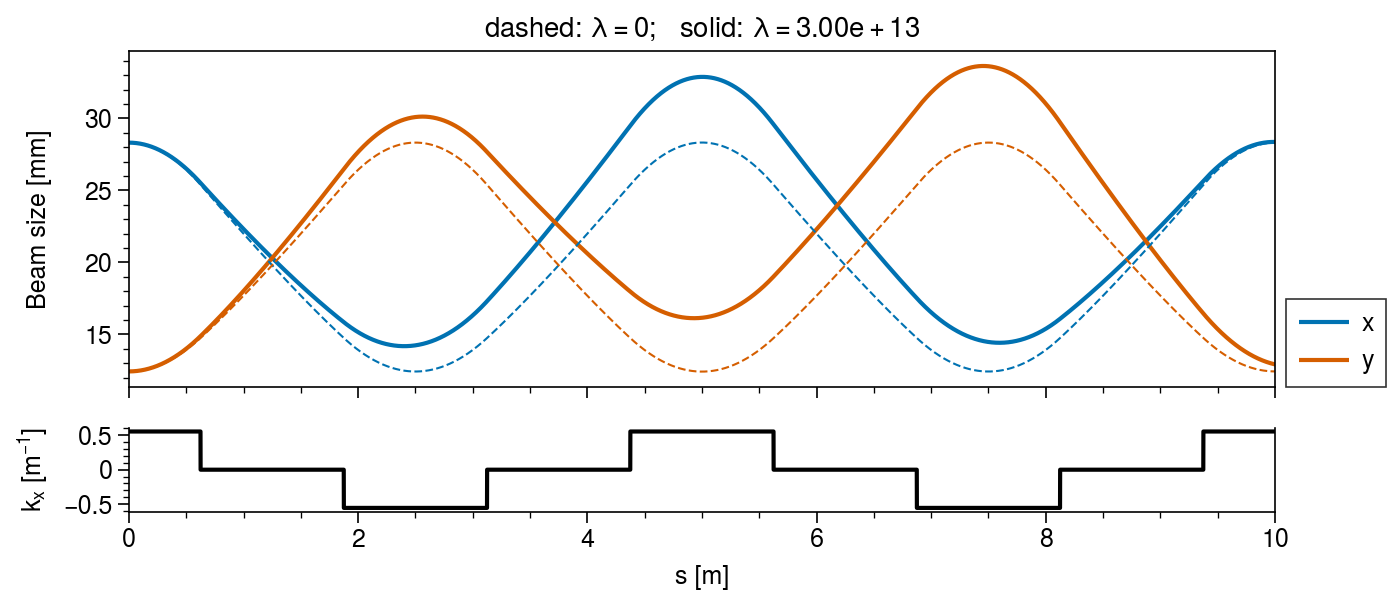

In [6]:
fig, axes = plot.subplots(nrows=2, figsize=(7, 3), height_ratios=[4, 1], 
                          spany=False, aligny=True)
ax1, ax2 = axes
moments[['s','x_rms','y_rms']].plot('s', ax=ax1, legend=False)
ax1.format(cycle='colorblind')
moments_0sc[['s','x_rms','y_rms']].plot('s', ax=ax1, legend=False, ls='--', lw=0.75)
ax1.format(xlabel='s [m]', ylabel='Beam size [mm]', xlim=positions[[0, -1]],
           title='dashed: $\lambda = 0$;   solid: $\lambda = {:.2e}$'.format(line_density))
ax1.legend(labels=['x', 'y'], ncols=1, loc=(1.01, 0))

ax2.plot(positions, [k_fodo(s)[0] for s in positions], color='k')
ax2.spines['top'].set_visible(False)
ax2.format(ylabel='$k_x$ [$m^{-1}$]')
axes.format(grid=False)

## Perturbation around matched solution 

Now assume the matched solution is $\mathbf{y}^0$ and $\mathbf{y}^p$ is a small deviation from the matched solution. Plugging $\mathbf{y} = \mathbf{y}^0 + \mathbf{y}^p$ into Eq. (2) and keeping only linear terms gives

$$ \frac{d}{ds}\mathbf{y}^p = \mathbf{J}\mathbf{y}^p(0), \tag{4}$$

where $\mathbf{J}_{i,j} = d\mathbf{g}_i / d\mathbf{y}_j$. The exact solution to this equation is

$$ \mathbf{y}^p(s) = \mathbf{M}(s)\,\mathbf{y}^p(0) = e^{Js} \mathbf{y}^p(0). \tag{5}$$

Note that the exponential is defined by the Taylor expansion. The eigenvalues of $\mathbf{M}$ determine the stability of the system. If $\mathbf{Jv} = \lambda\mathbf{v}$, the eigenvalues of $\mathbf{M}$ are

$$ \mathbf{M}\mathbf{v} = \exp(\mathbf{J}s) \, \mathbf{v} = \sum_{l=0}^{\infty}\frac{s^l J^l}{l!}\mathbf{v} = \sum_{l=0}^{\infty}\frac{s^l \lambda^l}{l!}\mathbf{v} = \exp(\lambda s)\mathbf{v}. \tag{6}$$

In [7]:
Q = 0
yp = np.zeros(10)
frac_change = 0.01
yp[0] = frac_change * y0[0]
yp[7] = frac_change * y0[7]
perturbed_moments = ch.track_perturbed(yp, y0, Q, k_fodo, positions)

In [8]:
mismatched = moments_0sc + perturbed_moments
mismatched['s'] = positions

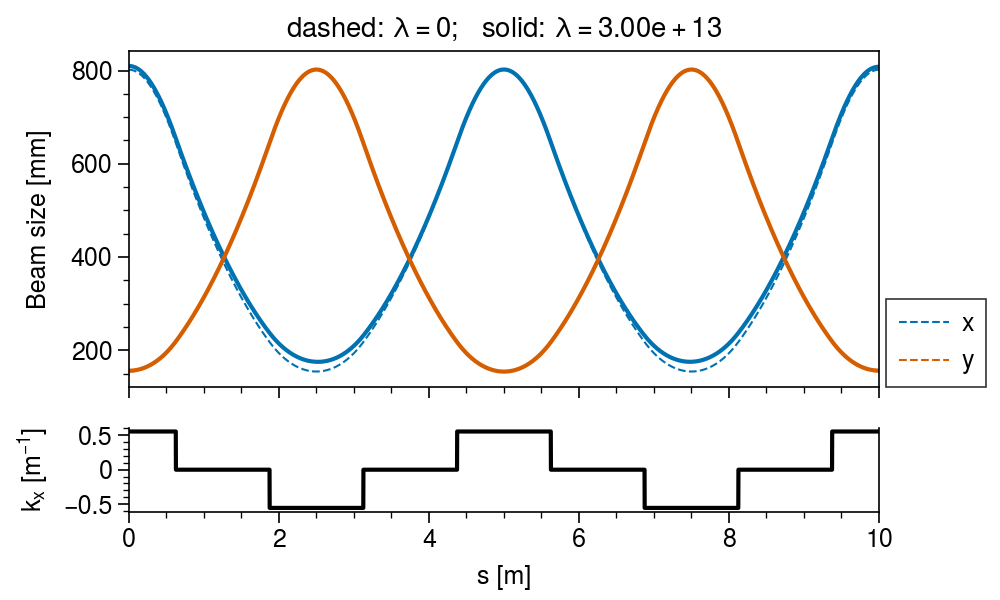

In [9]:
fig, axes = plot.subplots(nrows=2, figsize=(5, 3), height_ratios=[4, 1], spany=False, aligny=True)
ax1, ax2 = axes
moments_0sc[['s','x2','y2']].plot('s', ax=ax1, ls='--', lw=0.75, legend=False)
ax1.format(xlabel='s [m]', ylabel='Beam size [mm]', xlim=positions[[0, -1]], cycle='colorblind',
           title='dashed: $\lambda = 0$;   solid: $\lambda = {:.2e}$'.format(line_density))
mismatched[['s','x2','y2']].plot('s', ax=ax1, legend=False)
ax1.legend(labels=['x', 'y'], ncols=1, loc=(1.01, 0))

ax2.plot(positions, [k_fodo(s)[0] for s in positions], color='k')
ax2.spines['top'].set_visible(False)
ax2.format(ylabel='$k_x$ [$m^{-1}$]')
axes.format(grid=False)

## Check 

Integrate the envelope equations directly, without space charge, with a mismatched beam.

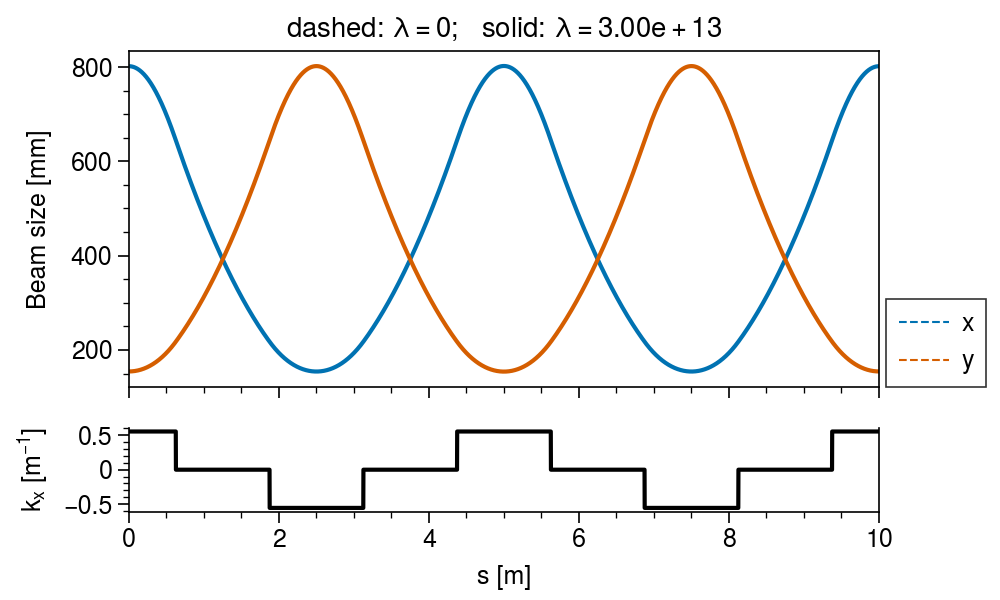

In [27]:
y0_check = np.copy(y0)
frac_change = 0.0
y0_check[0] *= (1 + frac_change)
y0_check[7] *= (1 - frac_change)
moments_0sc_check = ch.track(y0_check, 0.0, k_fodo, positions)

fig, axes = plot.subplots(nrows=2, figsize=(5, 3), height_ratios=[4, 1], spany=False, aligny=True)
ax1, ax2 = axes
moments_0sc[['s','x2','y2']].plot('s', ax=ax1, ls='--', lw=0.75, legend=False)
ax1.format(xlabel='s [m]', ylabel='Beam size [mm]', xlim=positions[[0, -1]], cycle='colorblind',
           title='dashed: $\lambda = 0$;   solid: $\lambda = {:.2e}$'.format(line_density))
moments_0sc_check[['s','x2','y2']].plot('s', ax=ax1, legend=False)
ax1.legend(labels=['x', 'y'], ncols=1, loc=(1.01, 0))

ax2.plot(positions, [k_fodo(s)[0] for s in positions], color='k')
ax2.spines['top'].set_visible(False)
ax2.format(ylabel='$k_x$ [$m^{-1}$]')
axes.format(grid=False)

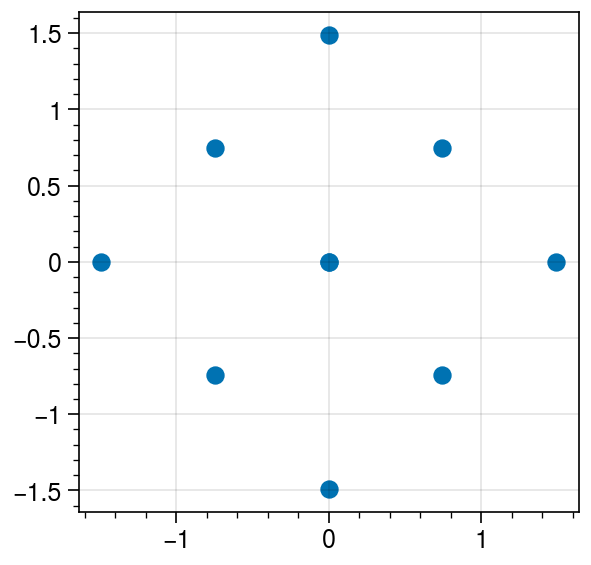

In [31]:
J = ch.jacobian(yp, 0.0, y0, 0.0, k_fodo)
jacobian_eigvals = np.linalg.eigvals(J)


eigvals = np.exp(jacobian_eigvals * cell_length)

fig, ax = plot.subplots()
ax.scatter(jacobian_eigvals.real, jacobian_eigvals.imag)